In [1]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
sys.path.append('/home/li.yu/code/JupiterCVML/europa/base/src/europa')
from utils import normalize_image, plot_image, plot_images

In [2]:
# load human pose info
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0209_v1.csv'
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0219_v2.csv'
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0222_v3.csv'
# human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0326_v4.csv'
human_pose_csv = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/all_human_pose_0509_v5.csv'
hp_df = pd.read_csv(human_pose_csv, converters={"properties__json": ast.literal_eval})
hp_df.drop('id', axis=1, inplace=True)
hp_df.rename({'image': 'id'}, axis=1, inplace=True)
# hp_df.drop_duplicates(subset='id', inplace=True)
print(hp_df.shape)

# combine labels
g = hp_df.groupby('id')
data = {'id':[], 'properties__json':[]}
for name, dfg in g:
    data['id'].append(name)
    if len(dfg) == 1:
        data['properties__json'].append(dfg.iloc[0].properties__json)
    else:
        ls = dfg.properties__json.to_list()
        data['properties__json'].append([d for l in ls for d in l])
hp_df2 = pd.DataFrame(data=data)
print(hp_df2.shape)

hp_df2.head(2)

(188786, 2)
(168478, 2)


,id,properties__json
0,5df9238180a73f861bcc1d3b,"[{'featureId': 'cls9v9rs9001u356nr555d3qz', 's..."
1,5df923b980a73f861bcd0f07,"[{'featureId': 'cls9txj8x0016356nv2nq7f25', 's..."


In [6]:
def get_human_pose(row):
    for label in row.properties__json:
        if label['title'] == 'Pose':
            row['Pose'] = label['answer']['title']
        if label['title'] == 'Human Clothing':
            row['Human Clothing'] = label['answer']['title']
        if label['title'] == 'Human Occlusion':
            row['Human Occlusion'] = label['answer']['title']
    return row

def get_camera_pod(df, halo_data=True):
    if halo_data:
        from dl.utils.config_halo import HALO_CAMERAS_TO_PODS
        df['camera_pod'] = df['camera_location'].apply(lambda s: HALO_CAMERAS_TO_PODS[s])
    else:
        REV1_CAMERAS_TO_PODS = {'side-left-left': 'rear', 'side-right-left': 'rear', 'front-left-left': 'front',
                                'front-center-left': 'front', 'front-right-left': 'front', 'rear-left': 'rear',
                                'front-center-right': 'front', 'side-left-right': 'rear'}
        df['camera_pod'] = df['camera_location'].apply(lambda s: REV1_CAMERAS_TO_PODS[s])
    return df

def prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=True, within_datasets=[]):
    print(f'loading dataset {dataset}')
    csv = os.path.join(root_dir, dataset, csv)
    # converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
    converters = {}
    df = pd.read_csv(csv, converters=converters)
    print('csv as loaded', df.shape)

    # get ids within provided datasets
    if len(within_datasets) > 0:
        within_ids = set([unique_id for d in within_datasets for unique_id in list(pd.read_csv(os.path.join(root_dir, d, 'master_annotations.csv')).unique_id.unique())])
        df = df[df.unique_id.isin(within_ids)]
        print('within ids', df.shape)

    # drop duplicates on id
    df.drop_duplicates(subset='unique_id', inplace=True)
    df = get_camera_pod(df, halo_data)
    print('drop duplicated unique_id', df.shape)

    # load depth/distance info
    if os.path.isfile(dist_csv_path):
        dist_df = pd.read_csv(dist_csv_path).drop_duplicates(subset='unique_id')
        final_df = df.merge(dist_df, on='unique_id')
        print('merge with dist df and get pod info', final_df.shape)
    else:
        final_df = df

    # # remove non-human images
    # if not 'is_human_present' in final_df:
    #     final_df['is_human_present'] = final_df['humans_pixel_count'].apply(lambda pc: 'Yes' if pc > 0 else 'No')
    # final_df = final_df[final_df['is_human_present'] == 'Yes']
    # print('drop non-human image', final_df.shape)

    # # merge human pose df
    # if hp_df is not None:
    #     final_df2 = final_df.merge(hp_df, on='id', how='inner')
    #     print('merge with human pose info', final_df2.shape)
    #     # retrieve human pose info
    #     final_df2['Pose'] = ''
    #     final_df2['Human Clothing'] = ''
    #     final_df2['Human Occlusion'] = 'non_occluded'
    #     final_df2 = final_df2.apply(lambda r: get_human_pose(r), axis=1)
    #     print('retrieve human pose info from outside df', final_df2.shape)
    # else:
    #     # retrieve human pose info
    #     final_df['Pose'] = final_df['pose_human_tagged'].fillna('')
    #     final_df['Human Clothing'] = final_df['human_clothing_human_tagged'].fillna('')
    #     final_df['Human Occlusion'] = final_df['human_occlusion_human_tagged'].fillna('non_occluded')
    #     final_df2 = final_df
    #     print('retrieve human pose info from own info', final_df2.shape)
    # print()
    final_df2 = final_df
    return final_df, final_df2

In [8]:
# # Halo train v6.2
# root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_rgb_stereo_train_v6_2'
# csv = 'master_annotations_dedup.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_2_full_res.csv'
# halo_data = True
# # halo_train_full_df_ori, halo_train_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# # Halo train v8.0
# root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_rgb_stereo_train_v8_0'
# csv = 'master_annotations.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v8_0.csv'
# halo_data = True
# halo_train_full_df_ori2, halo_train_hp_df_ori2 = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# Halo train v10.0
root_dir = '/data2/jupiter/datasets/'
dataset = 'halo_rgb_stereo_train_v10_0'
csv = 'master_annotations.csv'
dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v10_0.csv'
halo_data = True
hp_df = None
halo_train_full_df_ori2, halo_train_hp_df_ori2 = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# # Rev1 train
# root_dir = '/data2/jupiter/datasets/'
# dataset = 'Jupiter_train_v6_2'
# csv = 'master_annotations.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/rev1_train_v6_2.csv'
# halo_data = False
# rev1_train_full_df_ori, rev1_train_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df, dist_csv_path, halo_data=halo_data)

# # Halo test
# # root_dir = '/data2/jupiter/datasets/'
# root_dir = '/data/jupiter/datasets/safety_datasets'
# # dataset = 'human_annotations_interim_halo_v6_2_mainline'
# # dataset = 'human_annotations_interim_halo_v6_2_3_mainline'
# # dataset = 'halo_humans_on_path_test_v6_2_3_mainline'
# # dataset = 'halo_rgb_stereo_test_v8_0'
# dataset = 'humans/on_path_forward/on_path_forward_humans_day_2024_rev2_v12_maxfov_alleysson_depth0423'
# # dataset = 'humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v14_maxfov_alleysson_depth0423'
# csv = 'master_annotations.csv'
# human_pose_df = None  # use one's own pose/clothing/occlusion info
# # dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v8_0.csv'
# dist_csv_path = ''
# halo_data = True
# # within_datasets = ['on_path_forward_human_day_2024_rev2_v1', 'on_path_forward_human_night_2024_rev2_v1', 
# #     'on_path_forward_humans_day_2024_rev2_v2', 'on_path_forward_humans_night_2024_rev2_v2', 
# #     'on_path_forward_humans_night_2024_rev2_v3', 'on_path_aft_human_night_2024_rev2_v1', 
# #     'on_path_aft_humans_day_2024_rev2_v2', 'on_path_aft_humans_day_2024_rev2_v2_stereo', 'on_path_aft_humans_night_2024_rev2_v2', 
# #     'on_path_aft_vehicle_day_2024_rev2_v2',]
# within_datasets = []
# halo_test_full_df_ori, halo_test_hp_df_ori = prepare_df(root_dir, dataset, csv, human_pose_df, dist_csv_path, halo_data=halo_data, within_datasets=within_datasets)

# # Rev1 test
# # root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/rev1_ask_ben_cline_before_deleting'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# csv = 'master_annotations.csv'
# dist_csv_path = '/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/rev1_test_humanv15.csv'
# halo_data = False
# rev1_test_full_df_ori, rev1_test_hp_df_ori = prepare_df(root_dir, dataset, csv, hp_df2, dist_csv_path, halo_data=halo_data)

loading dataset halo_rgb_stereo_train_v10_0


<ipython-input-8-40852daba7da>:24: DtypeWarning: Columns (0,1,16,24,36,77,82,90,94,95,96,97,98,100,101,103,104,105,106,107,108,109,110,111,116,121,128,152,155,156,159,160,161,165,167,168,172,175,178,181,182,184,187,188,191,195,197,201,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,240,241,257,258,260,262,264,265,266,269,271,273,274,275,276,277,278,289,290,292,294,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,317,318,319,321,325,326,327,328,331,332,333,335,360,374,382,383,384,385,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,413,414,415,416,417,418,419,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,449,450,451,452,453,454,455,457,458,459,460,461,462,463,464,465,466,467,468,469,471,472,473,474,475,476,477,478,479,480,481,483,484,485,486,487,489,490,491,492,493,494,495,496,497,498,499,500,502,503,504,505,5

csv as loaded (387358, 714)
drop duplicated unique_id (387358, 715)
merge with dist df and get pod info (387358, 734)


In [9]:
# halo_train_hp_df = halo_train_hp_df_ori
# halo_test_hp_df = halo_train_hp_df_ori2
halo_train_hp_df = halo_train_full_df_ori2
halo_test_hp_df = halo_train_full_df_ori2
print(halo_train_hp_df.shape, halo_test_hp_df.shape)

(387358, 734) (387358, 734)


In [10]:
all_pose = list(set(halo_train_hp_df.Pose.unique()) | set(halo_test_hp_df.Pose.unique()))
all_clothing = list(set(halo_train_hp_df['Human Clothing'].unique()) | set(halo_test_hp_df['Human Clothing'].unique()))
all_occlusion = list(set(halo_train_hp_df['Human Occlusion'].unique()) | set(halo_test_hp_df['Human Occlusion'].unique()))
all_pose.sort()
all_clothing.sort()
all_occlusion.sort()
print(all_pose)
print(all_clothing)
print(all_occlusion)

['', 'bent_over', 'carrying_object', 'crouching_kneeling_sitting_squatting', 'greeting_embrace', 'holding_child', 'leaning', 'lifting_object', 'lying_down', 'pointing', 'pushing_object', 'reading_phone_book_object', 'running_walking', 'standing_hands_down']
['', 'bright_clothing', 'camo_clothing', 'dark_clothing', 'mixed_clothing']
['non_occluded', 'occluded_human']


12 12


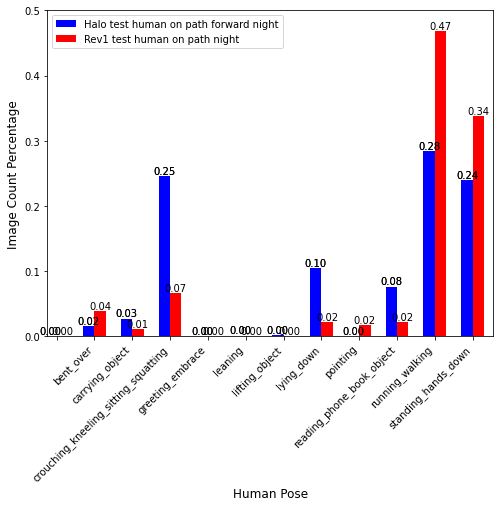

In [50]:
halo_train_g = halo_train_hp_df[['id', 'Pose']].groupby('Pose').count() / len(halo_train_hp_df)
# halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
# halo_train_g.rename(columns={"id": "Halo train v6.2"}, inplace=True)
# halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_train_g.rename(columns={"id": "Halo test human on path forward night"}, inplace=True)
halo_test_g = halo_test_hp_df[['id', 'Pose']].groupby('Pose').count() / len(halo_test_hp_df)
halo_test_g.drop(['holding_child', 'pushing_object'], inplace=True)
# halo_test_g.rename(columns={"id": "Halo train v8.0"}, inplace=True)
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
# halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 test human on path night"}, inplace=True)
print(len(halo_train_g), len(halo_test_g))

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.3, sharex=True, sharey=True)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')
ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.3, sharex=True, sharey=True)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 0.5)
plt.xlabel("Human Pose", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

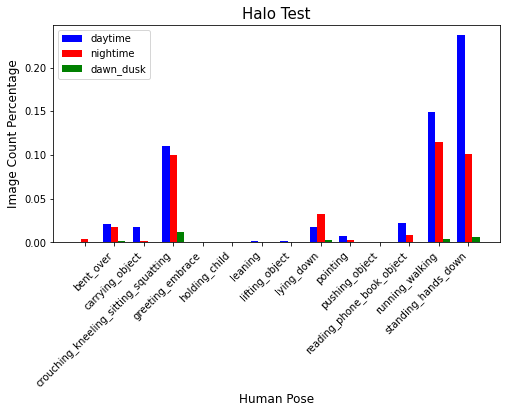

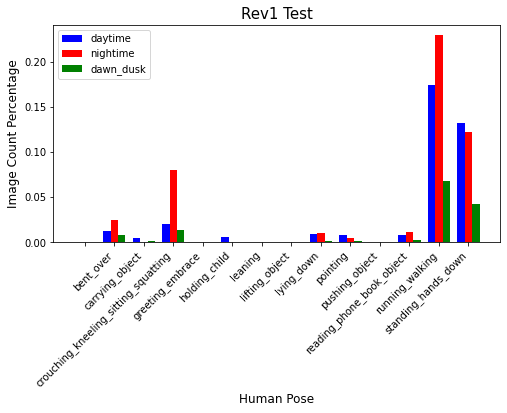

In [8]:
# human pose per operation time
def human_pose_dist_vs_op_time(halo_train_hp_df, title):
    halo_train_g = halo_train_hp_df[['id', 'Pose', 'operation_time']].groupby(['operation_time', 'Pose']).size().reset_index(name='counts')

    N = len(all_pose)
    ind = np.arange(N)
    width = 0.25

    fig = plt.figure(1, figsize=(8, 4))
    op_times = ['daytime', 'nightime', 'dawn_dusk']
    bars, colors = [], ['b', 'r', 'g']
    for i, (op_time, c) in enumerate(zip(op_times, colors)):
        sub_df = halo_train_g[halo_train_g.operation_time == op_time]
        counts_d = dict(zip(sub_df['Pose'], sub_df['counts']))
        counts = [counts_d.get(p, 0) / len(halo_train_hp_df) for p in all_pose]
        bar = plt.bar(ind+width*i, counts, width, color=c)
        bars.append(bar)
    plt.xlabel('Human Pose', fontsize=12)
    plt.ylabel('Image Count Percentage', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xticks(ind+width, all_pose, rotation=45, ha='right')
    plt.legend(bars, op_times)
    plt.show()

# human_pose_dist_vs_op_time(halo_train_hp_df, "Halo Train")
# human_pose_dist_vs_op_time(halo_train_hp_df, "Rev1 Train")
human_pose_dist_vs_op_time(halo_train_hp_df, "Halo Test")
# human_pose_dist_vs_op_time(halo_test_hp_df, "Halo Test")
# human_pose_dist_vs_op_time(halo_test_hp_df, "Rev1 Train")
human_pose_dist_vs_op_time(halo_test_hp_df, "Rev1 Test")

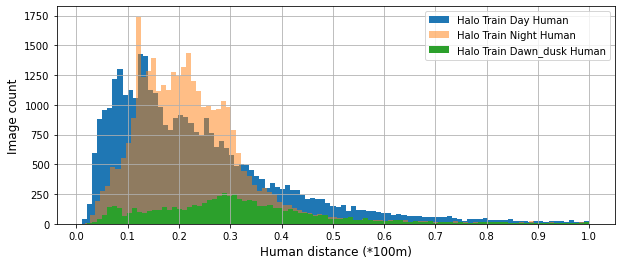

In [10]:
# human pose per distance

# # general
# plt.figure(1, figsize=(10, 6))
# halo_train_hp_df[(halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
# # plt.legend(['Halo Train', 'Halo Test'])
# # plt.legend(['Halo Train', 'Rev1 Train'])
# # plt.legend(['Rev1 Train', 'Rev1 Test'])
# plt.legend(['Halo Test', 'Rev1 Test'])

# # lying down vs. standing
# plt.figure(1, figsize=(10, 4))
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # halo_train_hp_df[(halo_train_hp_df['Pose'].isin(['lying_down'])) & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # # plt.legend(['Halo Train Standing Human', 'Halo Train Lying Down Human'])
# # # plt.legend(['Rev1 Train Standing Human', 'Rev1 Train Lying Down Human'])
# # plt.legend(['Halo Test Standing Human', 'Halo Test Lying Down Human'])
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['running_walking', 'standing_hands_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['Pose'].isin(['lying_down'])) & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Test Standing Human', 'Halo Test Lying Down Human'])
# # plt.legend(['Rev1 Train Standing Human', 'Rev1 Train Lying Down Human'])
# # plt.legend(['Rev1 Test Standing Human', 'Rev1 Test Lying Down Human'])
# plt.legend(['Rev1 Test Standing Human', 'Rev1 Test Lying Down Human'])

# day vs night
plt.figure(1, figsize=(10, 4))
halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'daytime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'nightime') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
halo_train_hp_df[(halo_train_hp_df['operation_time'] == 'dawn_dusk') & (halo_train_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
plt.legend(['Halo Train Day Human', 'Halo Train Night Human', 'Halo Train Dawn_dusk Human'])
# plt.legend(['Rev1 Train Day Human', 'Rev1 Train Night Human', 'Rev1 Train Dawn_dusk Human'])
# plt.legend(['Halo Test Day Human', 'Halo Test Night Human', 'Halo Test Dawn_dusk Human'])
# halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'daytime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'nightime') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100, alpha=0.5)
# halo_test_hp_df[(halo_test_hp_df['operation_time'] == 'dawn_dusk') & (halo_test_hp_df['human_90_percentile_depth'] < 1.0)]['human_90_percentile_depth'].hist(bins=100)
# # plt.legend(['Halo Test Day Human', 'Halo Test Night Human', 'Halo Test Dawn_dusk Human'])
# # plt.legend(['Rev1 Train Day Human', 'Rev1 Train Night Human', 'Rev1 Train Dawn_dusk Human'])
# plt.legend(['Rev1 Test Day Human', 'Rev1 Test Night Human', 'Rev1 Test Dawn_dusk Human'])

plt.xticks([i/10 for i in range(0, 11)])
plt.xlabel('Human distance (*100m)', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()

In [18]:
halo_train_hp_df = halo_train_full_df_ori2[(halo_train_full_df_ori2['operation_time'] == 'daytime') & (halo_train_full_df_ori2.is_human_present == 'Yes')]
halo_test_hp_df = halo_train_full_df_ori2[(halo_train_full_df_ori2['operation_time'] == 'nightime') & (halo_train_full_df_ori2.is_human_present == 'Yes')]
print(halo_train_hp_df.shape, halo_test_hp_df.shape)

(37506, 734) (35697, 734)


<ipython-input-19-91ac0ad1421e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  halo_train_hp_df['human_mid_row'] = halo_train_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)  # / 4 for halo train
<ipython-input-19-91ac0ad1421e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  halo_test_hp_df['human_mid_row'] = halo_test_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)


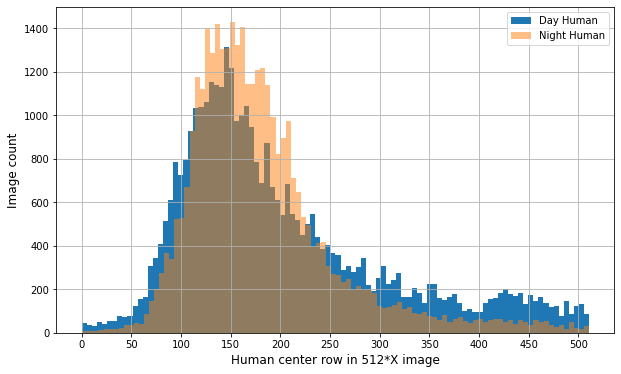

In [19]:
# human location on image
halo_train_hp_df['human_mid_row'] = halo_train_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)  # / 4 for halo train
halo_test_hp_df['human_mid_row'] = halo_test_hp_df.apply(lambda r: (r['human_min_row'] + r['human_max_row']) / 2, axis=1)
plt.figure(1, figsize=(10, 6))
halo_train_hp_df['human_mid_row'].hist(bins=100)
halo_test_hp_df['human_mid_row'].hist(bins=100, alpha=0.5)
# plt.legend(['Halo Train', 'Rev1 Train'])
# plt.legend(['Halo Test', 'Rev1 Test'])
plt.legend(['Day Human', 'Night Human'])
plt.xticks([i for i in range(0, 512, 50)])
plt.xlabel('Human center row in 512*X image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

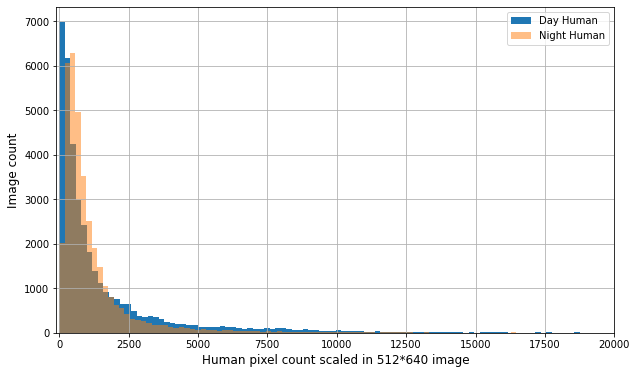

In [20]:
# human pixel counts on image
def scale_pixels(row):
    s = row.image_size
    h, w = s[1:-1].split(', ')
    h, w = int(h), int(w)
    row['human_pixels_scaled'] = row['human_pixels'] / (h * w) * (512 * 640)
    return row

halo_train_hp_df = halo_train_hp_df.apply(lambda r: scale_pixels(r), axis=1)
halo_test_hp_df = halo_test_hp_df.apply(lambda r: scale_pixels(r), axis=1)

plt.figure(1, figsize=(10, 6))
pixel_limit = 20000
halo_train_hp_df[halo_train_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100)
halo_test_hp_df[halo_test_hp_df['human_pixels_scaled'] < pixel_limit]['human_pixels_scaled'].hist(bins=100, alpha=0.5)
# plt.legend(['Halo Train', 'Rev1 Train'])
# plt.legend(['Halo Test', 'Rev1 Test'])
plt.legend(['Day Human', 'Night Human'])
# plt.xticks([i for i in range(0, 512, 50)])
plt.xlim(-100, pixel_limit)
plt.xlabel('Human pixel count scaled in 512*640 image', fontsize=12)
plt.ylabel('Image count', fontsize=12)
plt.show()
plt.show()

3053 7826


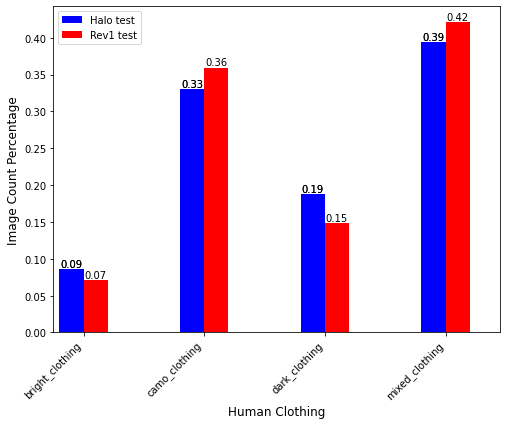

In [53]:
# halo_train_hp_df_clothing = halo_train_hp_df
# halo_test_hp_df_clothing = halo_test_hp_df
halo_train_hp_df_clothing = halo_train_hp_df[halo_train_hp_df['Human Clothing'] != '']
halo_test_hp_df_clothing = halo_test_hp_df[halo_test_hp_df['Human Clothing'] != '']
print(len(halo_train_hp_df_clothing), len(halo_test_hp_df_clothing))

halo_train_g = halo_train_hp_df_clothing[['id', 'Human Clothing']].groupby('Human Clothing').count() / len(halo_train_hp_df_clothing)
# halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
# halo_train_g.rename(columns={"id": "Halo train v6.2"}, inplace=True)
# halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_train_g.rename(columns={"id": "Halo test"}, inplace=True)
halo_test_g = halo_test_hp_df_clothing[['id', 'Human Clothing']].groupby('Human Clothing').count() / len(halo_test_hp_df_clothing)
# halo_test_g.rename(columns={"id": "Halo train v8.0"}, inplace=True)
# halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
# halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
halo_test_g.rename(columns={"id": "Rev1 test"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')
ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Human Clothing", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

(16154, 259) (10, 259)


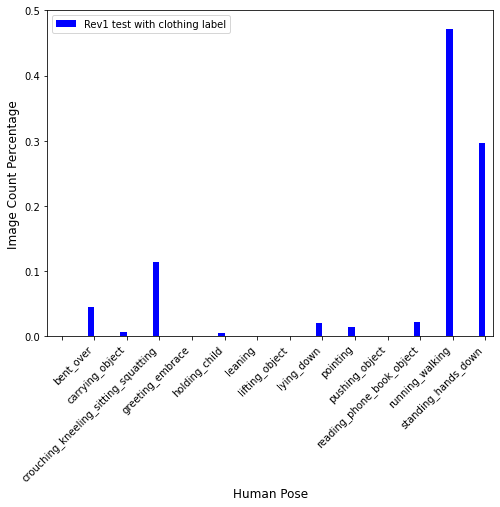

In [13]:
# check missed human clothing labels in rev1 test set
hp_labeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] != '']
hp_unlabeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] == '']
print(hp_labeled_df.shape, hp_unlabeled_df.shape)

halo_train_g = hp_labeled_df[['id', 'Pose']].groupby('Pose').count() / len(hp_labeled_df)
halo_train_g.rename(columns={"id": "Rev1 test with clothing label"}, inplace=True)
halo_test_g = hp_unlabeled_df[['id', 'Pose']].groupby('Pose').count() / len(hp_unlabeled_df)
halo_test_g.rename(columns={"id": "Rev1 test without clothing label"}, inplace=True)

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
# halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)  # number of bars are different
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 0.5)
plt.xlabel("Human Pose", fontsize=12)
plt.ylabel("Image Count Percentage", fontsize=12)
plt.show()

In [53]:
halo_train_hp_df.camera_pod.unique(), halo_test_hp_df.camera_pod.unique()

(array(['front', 'right', 'rear', 'left'], dtype=object),
 array(['front', 'rear'], dtype=object))

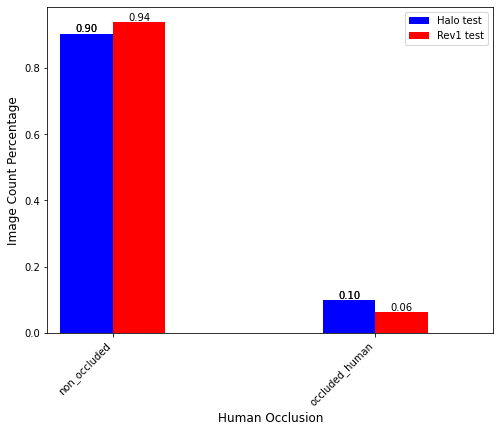

4490 6815


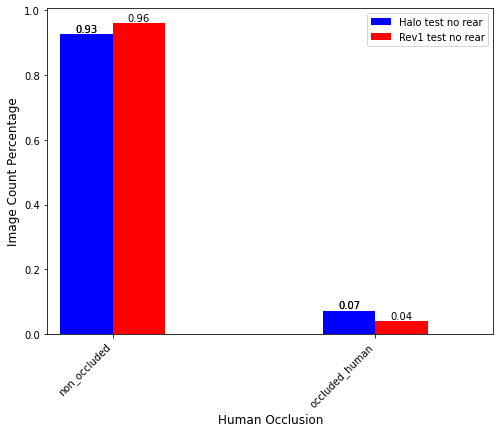

In [54]:
def plot_human_occlusion_dist(halo_train_hp_df, halo_test_hp_df, legend_pad1='', legend_pad2=''):
    halo_train_g = halo_train_hp_df[['id', 'Human Occlusion']].groupby('Human Occlusion').count() / len(halo_train_hp_df)
    # halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
    # halo_train_g.rename(columns={"id": f"Halo train v6.2{legend_pad1}"}, inplace=True)
    # halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_train_g.rename(columns={"id": f"Halo test{legend_pad1}"}, inplace=True)
    halo_test_g = halo_test_hp_df[['id', 'Human Occlusion']].groupby('Human Occlusion').count() / len(halo_test_hp_df)
    # halo_test_g.rename(columns={"id": f"Halo train v8.0{legend_pad2}"}, inplace=True)
    # halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
    # halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_test_g.rename(columns={"id": f"Rev1 test{legend_pad2}"}, inplace=True)

    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax1 = halo_train_g.plot.bar(rot=0, color='blue', ax=ax, position=1.0, width=0.2, sharex=True, sharey=True)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f')
    ax2 = halo_test_g.plot.bar(rot=0, color='red', ax=ax, position=0.0, width=0.2, sharex=True, sharey=True)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Human Occlusion", fontsize=12)
    plt.ylabel("Image Count Percentage", fontsize=12)
    plt.show()

def plot_human_occlusion_dist_stack(halo_train_hp_df, halo_test_hp_df, legend_pad1='', legend_pad2=''):
    halo_train_g = halo_train_hp_df[['id', 'Human Occlusion', 'Pose']].groupby(['Human Occlusion', 'Pose']).size().unstack() / len(halo_train_hp_df)
    # halo_train_g.rename(columns={"id": "Halo train"}, inplace=True)
    # halo_train_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_train_g.rename(columns={"id": f"Halo test{legend_pad1}"}, inplace=True)
    halo_test_g = halo_test_hp_df[['id', 'Human Occlusion', 'Pose']].groupby(['Human Occlusion', 'Pose']).size().unstack() / len(halo_test_hp_df)
    # halo_test_g.rename(columns={"id": "Halo test"}, inplace=True)
    # halo_test_g.rename(columns={"id": "Rev1 train"}, inplace=True)
    halo_test_g.rename(columns={"id": f"Rev1 test{legend_pad2}"}, inplace=True)

    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax1 = halo_train_g.plot.bar(rot=0, ax=ax, position=1.0, width=0.2, sharex=True, sharey=True, stacked=True)
    # for container in ax1.containers:
    #     ax1.bar_label(container, fmt='%.2f')
    ax2 = halo_test_g.plot.bar(rot=0, ax=ax, position=0.0, width=0.2, sharex=True, sharey=True, stacked=True)
    # for container in ax2.containers:
    #     ax2.bar_label(container, fmt='%.2f')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Human Occlusion", fontsize=12)
    plt.ylabel("Image Count Percentage", fontsize=12)
    plt.show()


halo_train_hp_df_sub = halo_train_hp_df[halo_train_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down'])]
halo_test_hp_df_sub = halo_test_hp_df[halo_test_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down'])]
plot_human_occlusion_dist(halo_train_hp_df, halo_test_hp_df)
# plot_human_occlusion_dist_stack(halo_train_hp_df_sub, halo_test_hp_df_sub)

halo_train_hp_df_sub = halo_train_hp_df[(halo_train_hp_df['camera_pod'].isin(['front', 'left', 'right'])) & (halo_train_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down']))]
halo_test_hp_df_sub = halo_test_hp_df[(halo_test_hp_df['camera_pod'].isin(['front', 'left', 'right'])) & (halo_test_hp_df['Pose'].isin(['lying_down', 'running_walking', 'standing_hands_down']))]
print(len(halo_train_hp_df_sub), len(halo_test_hp_df_sub))
plot_human_occlusion_dist(halo_train_hp_df_sub, halo_test_hp_df_sub, ' no rear', ' no rear')
# plot_human_occlusion_dist_stack(halo_train_hp_df_sub, halo_test_hp_df_sub, ' no rear', ' no rear')

## Show example images

In [59]:
# sub_df = df[df.id == df.sample(1).iloc[0].id]
# print(sub_df.shape)

# sub_df = halo_train_hp_df[halo_train_hp_df['Human Clothing'] == '']
# print(sub_df.shape)

# sub_df = halo_train_hp_df[halo_train_hp_df['human_90_percentile_depth'] < 0.1]
# print(sub_df.shape)

# root_dir = '/data/jupiter/datasets/'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# # hp_unlabeled_df = rev1_test_full_df_ori[~rev1_test_full_df_ori.id.isin(rev1_test_hp_df_ori.id)]
# hp_unlabeled_df = rev1_test_hp_df_ori[rev1_test_hp_df_ori['Human Clothing'] == '']
# sub_df = hp_unlabeled_df
# print(sub_df.shape)

# root_dir = '/data2/jupiter/datasets/'
# dataset = 'halo_humans_on_path_test_v6_2_3_mainline'
# # sub_df = halo_train_hp_df_sub[(halo_train_hp_df_sub['Pose'] == 'lying_down') & (halo_train_hp_df_sub['Human Occlusion'] == 'occluded_human')]
# sub_df = halo_train_hp_df_sub[(halo_train_hp_df_sub['Human Occlusion'] == 'occluded_human')]
# print(sub_df.shape)

root_dir = '/data/jupiter/datasets/safety_datasets'
# dataset = 'humans/on_path_forward/on_path_forward_humans_day_2024_rev2_v12_maxfov_alleysson_depth0423'
dataset = 'humans/on_path_forward/on_path_forward_humans_night_2024_rev2_v14_maxfov_alleysson_depth0423'
miss_pose_df = halo_train_hp_df[halo_train_hp_df.Pose == '']
print(miss_pose_df.shape)

(950, 354)


654570e1a19eb58b9d182ee4 654570e1a19eb58b9d182ee4_T14_T15 T14 nan nan nan


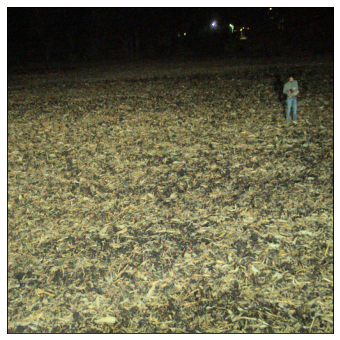

65e78a5ac69b4ce2d0bc1728 65e78a5ac69b4ce2d0bc1728_T06_T08 T06 nan nan nan


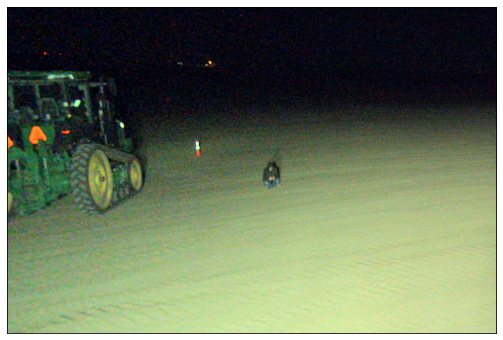

65e999274875033da619acfc 65e999274875033da619acfc_T06_T07 T06 nan nan nan


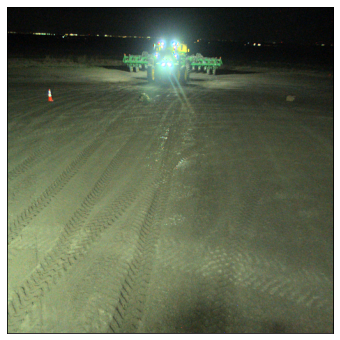

65e1f12ec20767850b15d9a8 65e1f12ec20767850b15d9a8_T02_T03 T02 nan nan nan


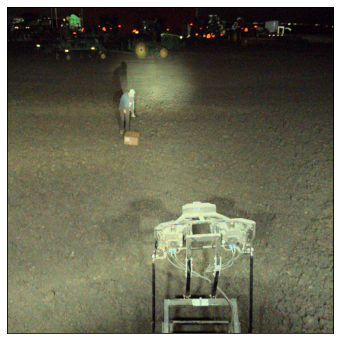

65e9800d5e301af12daa7b6e 65e9800d5e301af12daa7b6e_T02_T03 T02 nan nan nan


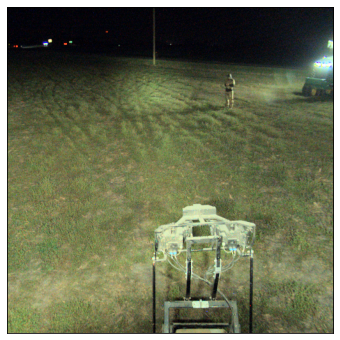

65e98a6ee4305312190a8c59 65e98a6ee4305312190a8c59_T02_T03 T02 nan nan nan


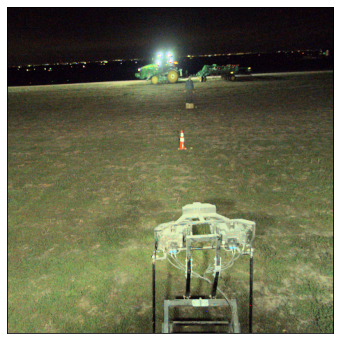

65e99390bc620c2c14fdd77d 65e99390bc620c2c14fdd77d_T06_T07 T06 nan nan nan


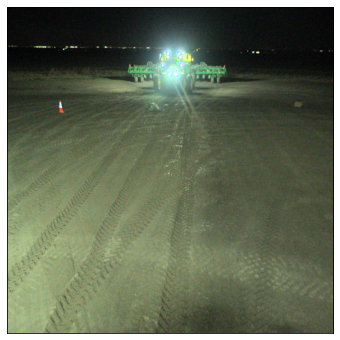

65ea10d6729c6fb74afff9aa 65ea10d6729c6fb74afff9aa_T14_T15 T14 nan nan nan


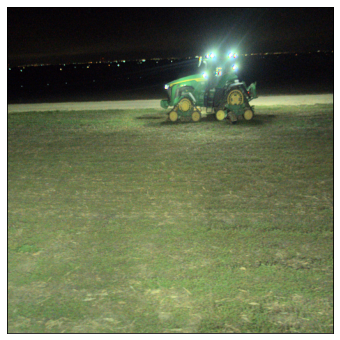

6558ae2d2289b4a6fb6854f0 6558ae2d2289b4a6fb6854f0_T06_T08 T06 nan nan nan


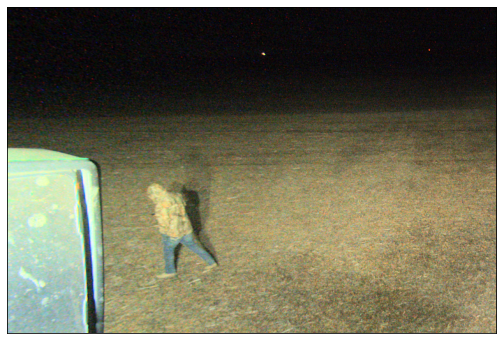

65c14fc2702922c0f4923b48 65c14fc2702922c0f4923b48_T06_T08 T06 nan nan nan


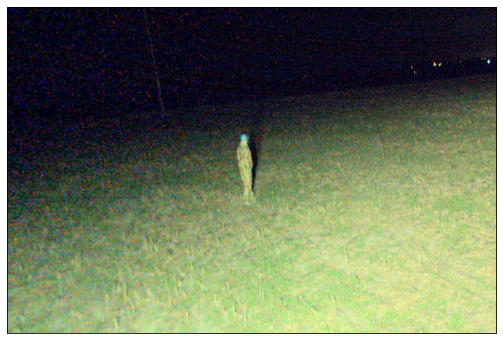

In [66]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
# sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['64f24c35185004ffd6db442a_T13_T15', '64f103a37f23cbe32a523272_I02_I04'])]
# sub_df = df2.sample(5)
# sub_df = df[df.id.isin(['652e0369252effd494936bb6', '6441f9199b12538afbfcc044'])]
sub_df = miss_pose_df.sample(10)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False

for i, row in sub_df.iterrows():
    # print(row.id, row.unique_id, row.camera_location, row['Human Occlusion'])
    # print(row.id, row.unique_id, row.camera_location, row.humans_pixel_count, row.is_multi_human, row.pose_human_tagged, row.human_clothing_human_tagged, row.human_occlusion_human_tagged)
    print(row.id, row.unique_id, row.camera_location, row.pose_human_tagged, row.human_clothing_human_tagged, row.human_occlusion_human_tagged)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map = row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label)